In [ ]:
import spikeinterface.full as si
import matplotlib.pyplot as plt
import numpy as np
import probeinterface as pi
from pathlib import Path
import os 
import pandas as pd 

global_job_kwargs = dict(n_jobs=4, chunk_duration="1s",progress_bar=True)
si.set_global_job_kwargs(**global_job_kwargs)


basefolder="F:/copydaya/M7_1_copy"

metapath = basefolder + str('/Meta')
if not os.path.isdir(metapath):
   os.makedirs(metapath)


recording =  si.read_spikeglx(basefolder, stream_id='imec1.ap', load_sync_channel=False)
lfp = si.read_spikeglx(basefolder, stream_id='imec1.lf', load_sync_channel=False)
event =  si.read_spikeglx(basefolder, stream_id='nidq', load_sync_channel=False)
print(recording)

#recording = si.ChannelSliceRecording(recording, channel_ids=recording.get_channel_ids()[180:330])


In [ ]:


bad_channel_ids, channel_labels = si.detect_bad_channels(lfp,method = 'coherence+psd',outside_channels_location = 'both')
names = lfp.channel_ids
depth = lfp.get_channel_locations()[:,1]


ar = pd.DataFrame({'name':names, 'depth':depth, 'labels':channel_labels})
ar.to_csv(metapath + str('/lfp_labels.csv'))
filtered_ar = ar[ar['labels'] == 'out']

print(filtered_ar)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
si.plot_probe_map(recording4, ax=ax, with_channel_ids=True)
ax.set_ylim(-200,3000)

In [ ]:
rec1 = si.highpass_filter(recording, freq_min=400.)
rec1 = si.phase_shift(rec1)
bad_channel_ids, channel_labels = si.detect_bad_channels(rec1,method = 'coherence+psd')
print(bad_channel_ids)
rec1 = si.interpolate_bad_channels(recording=rec1, bad_channel_ids=bad_channel_ids)

rec1 = si.common_reference(rec1, operator="median", reference="global")
print(rec1)


%matplotlib widget
si.plot_traces({'raw':recording,'filtered':rec1}, backend='ipywidgets')

In [ ]:


def extract_and_save_ttl_events(data, bits, save_path):
    digital_signals = data.get_traces()
    digital_word = digital_signals[:, 0]
    sampling_rate = data.get_sampling_frequency()
    for bit in bits:
        # Extract TTL pulses for the current bit
        ttl_timestamps = extract_ttl_from_bit(digital_word, bit, sampling_rate)
        
        ttl_df = pd.DataFrame(ttl_timestamps, columns=['timestamps'])
        
        filename = f'ttl_{bit}.csv'
        
        ttl_df.to_csv(f"{save_path}/{filename}", index=False)
        print(f"Extracted TTL event timestamps for bit {bit} saved to {filename}")


def extract_ttl_from_bit(digital_word, bit, sampling_rate):
    # Extract the specific bit from the word (bit-shifting and masking)
    ttl_signal = (digital_word >> bit) & 1  # Right shift and mask to isolate the specific bit
    
    # Detect rising edges (0 -> 1 transitions)
    ttl_rising_edges = np.where(np.diff(ttl_signal) > 0)[0]
    
    # Convert sample indices to timestamps (in seconds)
    ttl_timestamps = ttl_rising_edges / sampling_rate
    
    return ttl_timestamps


bits_to_extract = [0, 1, 2]  
extract_and_save_ttl_events(event , bits_to_extract, metapath)

In [ ]:
from spikeinterface.sorters import installed_sorters
installed_sorters()
import torch
print(torch.cuda.is_available())
print(torch.cuda.current_device())
torch.cuda.get_device_name(0)

Sorting_KS4 = si.run_sorter(sorter_name="kilosort4", recording=rec1, folder=basefolder + str('/sorted'),remove_existing_folder=True)

In [ ]:
#Sorting_KS4 = si.read_kilosort(folder_path=basefolder + str('/sorted/sorter_output'))
analyzer = si.create_sorting_analyzer(Sorting_KS4, rec1, sparse=True, format="memory")



In [ ]:
analyzer.compute(['random_spikes', 'waveforms', 'templates', 'noise_levels','unit_locations','correlograms'],**global_job_kwargs)
analyzer.compute('spike_amplitudes')
analyzer.compute('principal_components', n_components = 5, mode="by_channel_local",**global_job_kwargs)

In [ ]:
metric_names=['firing_rate', 'presence_ratio', 'snr','isi_violation', 'amplitude_cutoff']
metrics = si.compute_quality_metrics(analyzer, metric_names=metric_names)


amplitude_cutoff_thresh = 0.1
isi_violations_ratio_thresh = 0.5
presence_ratio_thresh = 0.9


our_query = f"(amplitude_cutoff < {amplitude_cutoff_thresh}) & (isi_violations_ratio < {isi_violations_ratio_thresh}) & (presence_ratio > {presence_ratio_thresh})"

keep_units = metrics.query(our_query)
keep_unit_ids = keep_units.index.values
analyzer_clean = analyzer.select_units(keep_unit_ids, folder=basefolder +str('/analyzer_clean'), format='binary_folder')
print(analyzer)
print(analyzer_clean)


In [ ]:
si.plot_sorting_summary(sorting_analyzer=sorting_analyzer, curation=True, backend='spikeinterface_gui')

In [ ]:
si.export_to_phy(analyzer_clean, output_folder=basefolder + str('/sorted/phy'),**global_job_kwargs)

In [ ]:
!phy template-gui D:\Florian_paper\Florian\Data\Opto_2\M5686_2_g0\sorted\phy

In [ ]:
import os
import spikeinterface.full as si  # Assuming `si` is the module for loading the analyzer

import pandas as pd  # Ensure Pandas is imported
import matplotlib.pyplot as plt
from pathlib import Path  # For modern path handling

def find_key_in_dict(d, key_to_find):
    for key, value in d.items():
        if key == key_to_find:
            # If the value is a Pandas Series, convert it to a list
            if isinstance(value, pd.Series):
                return value.tolist()
            return value
        elif isinstance(value, dict):
            result = find_key_in_dict(value, key_to_find)
            if result:
                return result
        elif isinstance(value, list):
            for item in value:
                if isinstance(item, dict):
                    result = find_key_in_dict(item, key_to_find)
                    if result:
                        return result
    return None

# Base directory where subfolders are located
base_dir = Path("D:/Florian_paper/Florian/Data/Opto_2")


# Initialize a list to store all peak-to-valley values across subfolders
all_peak_to_valley_ms = []
original_indices = []  # To store the original indices for each value

# Iterate through all subfolders
for subfolder in base_dir.iterdir():  # Using pathlib to iterate
    if subfolder.is_dir():
        try:
            # Construct the full path and normalize it
            analyzer_path = subfolder / "analyzer_clean"
            analyzer_path = os.path.normpath(analyzer_path)  # Normalize the path
            print(analyzer_path)
            # Load the analyzer for the current subfolder
            analyzer = si.load_sorting_analyzer(str(analyzer_path))  # Convert to string if needed
            tm = analyzer.compute('template_metrics')
            dat = tm.data

            # Extract peak-to-valley data
            peak_to_valley_data = find_key_in_dict(dat['metrics'], 'peak_to_valley')
            
            # Check if peak_to_valley_data is found
            if peak_to_valley_data:
                # If it's a Pandas Series, convert it to a list
                if isinstance(peak_to_valley_data, pd.Series):
                    peak_to_valley_data = peak_to_valley_data.tolist()
                
                # Convert to milliseconds and append to the cumulative list
                peak_to_valley_ms = [value * 1000 for value in peak_to_valley_data]
                
                # Append the values and their original indices
                all_peak_to_valley_ms.extend(peak_to_valley_ms)
                original_indices.extend([f"{subfolder.name}_row_{i}" for i in range(len(peak_to_valley_ms))])
        
        except Exception as e:
            print(f"Error processing {subfolder}: {e}")

# Filter values below 0.425ms (450ms) from the list
filtered_peak_to_valley_ms = [
    (index, value) for index, value in zip(original_indices, all_peak_to_valley_ms) if value < 0.425
]

# Create a DataFrame from the filtered data, including the original indices
df_filtered = pd.DataFrame(filtered_peak_to_valley_ms, columns=["Original_Index", "Peak_to_Valley (ms)"])

# Display the DataFrame
print(df_filtered)

df_filtered.to_csv("C:/Users/Freitag/Desktop/Opto2.csv")


In [ ]:
import os
import spikeinterface.full as si  # Assuming `si` is the module for loading the analyzer

import pandas as pd  # Ensure Pandas is imported
import matplotlib.pyplot as plt
from pathlib import Path  # For modern path handling

def find_key_in_dict(d, key_to_find):
    for key, value in d.items():
        if key == key_to_find:
            # If the value is a Pandas Series, convert it to a list
            if isinstance(value, pd.Series):
                return value.tolist()
            return value
        elif isinstance(value, dict):
            result = find_key_in_dict(value, key_to_find)
            if result:
                return result
        elif isinstance(value, list):
            for item in value:
                if isinstance(item, dict):
                    result = find_key_in_dict(item, key_to_find)
                    if result:
                        return result
    return None
base_dir = Path("E:/Florian/Data/batch1")
all_peak_to_valley_ms = []
original_indices = []  

for subfolder in base_dir.iterdir():  # Using pathlib to iterate
    if subfolder.is_dir():
        try:
            # Construct the path for sorting output (fixed)
            sorting_output_path = subfolder / "sorted/sorter_output"
            sorting_output_path = os.path.normpath(sorting_output_path)  # Normalize the path

            # Search for a subfolder containing 'Record Node' and a number
            record_node_folders = [f for f in subfolder.iterdir() if "Record Node" in f.name]
            if not record_node_folders:
                print(f"No 'Record Node' found in {subfolder}. Skipping...")
                continue
            record_node_folder = record_node_folders[0]
            record_node_path = os.path.normpath(record_node_folder)  # Normalize the path
            
            # Print paths for debugging
            print(f"Sorting Output Path: {sorting_output_path}")
            print(f"Record Node Path: {record_node_path}")

            # Load Sorting (Kilosort) data
            Sorting_KS4 = si.read_kilosort(str(sorting_output_path))  # Ensure path is passed as string

            # Load OpenEphys data
            rec1 = si.read_openephys(str(record_node_path))

            # Download probe
            probe = pi.get_probe(manufacturer='cambridgeneurotech', probe_name='ASSY-77-H3')
            
            # Add wiring to device
            probe.wiring_to_device('ASSY-77>Adpt.A64-Om32_2x-sm-NN>RHD2164')

            # Set the probe for the current recording
            rec1.set_probe(probe, group_mode="by_shank", in_place=True)

            # Create the sorting analyzer with the loaded data
            analyzer = si.create_sorting_analyzer(Sorting_KS4, rec1, sparse=True, format="memory")

            # Compute the necessary metrics
            global_job_kwargs = {}  # You can define the global arguments here if needed
            analyzer.compute(['random_spikes', 'waveforms', 'templates'], **global_job_kwargs)

            # Compute 'template_metrics'
            tm = analyzer.compute('template_metrics')
            dat = tm.data

            peak_to_valley_data = find_key_in_dict(dat['metrics'], 'peak_to_valley')
            
            # Check if peak_to_valley_data is found
            if peak_to_valley_data:
                # If it's a Pandas Series, convert it to a list
                if isinstance(peak_to_valley_data, pd.Series):
                    peak_to_valley_data = peak_to_valley_data.tolist()
                
                # Convert to milliseconds and append to the cumulative list
                peak_to_valley_ms = [value * 1000 for value in peak_to_valley_data]
                
                # Append the values and their original indices
                all_peak_to_valley_ms.extend(peak_to_valley_ms)
                original_indices.extend([f"{subfolder.name}_row_{i}" for i in range(len(peak_to_valley_ms))])
        
        except Exception as e:
                print(f"Error processing {subfolder}: {e}")

# Filter values below 0.425ms (450ms) from the list
filtered_peak_to_valley_ms = [
    (index, value) for index, value in zip(original_indices, all_peak_to_valley_ms) if value < 0.425
]

# Create a DataFrame from the filtered data, including the original indices
df_filtered = pd.DataFrame(filtered_peak_to_valley_ms, columns=["Original_Index", "Peak_to_Valley (ms)"])

# Display the DataFrame
print(df_filtered)

df_filtered.to_csv("C:/Users/deepl/Desktop/Batch1.csv")




Sorting_KS4 = si.read_kilosort('path')  # Ensure path is passed as string
recording =  si.read_spikeglx(basefolder, stream_id='imec1.ap', load_sync_channel=False)
analyzer = si.create_sorting_analyzer(Sorting_KS4, rec1, sparse=True, format="memory")
analyzer.compute(['random_spikes', 'waveforms', 'templates'], **global_job_kwargs)

            # Compute 'template_metrics'
tm = analyzer.compute('template_metrics')
dat = tm.data
peak_to_valley_data = find_key_in_dict(dat['metrics'], 'peak_to_valley')
            
            # Check if peak_to_valley_data is found
if peak_to_valley_data:
                # If it's a Pandas Series, convert it to a list
    if isinstance(peak_to_valley_data, pd.Series):
        peak_to_valley_data = peak_to_valley_data.tolist()
                
                # Convert to milliseconds 
        peak_to_valley_ms = [value * 1000 for value in peak_to_valley_data]

C:\Users\Freitag\AppData\Local\anaconda3\envs\si_env\lib\site-packages\spikeinterface\core\sortinganalyzer.py:2043: UserWarning: Found no run_info file for correlograms, extension should be re-computed.
  warnings.warn(f"Found no run_info file for {self.extension_name}, extension should be re-computed.")
C:\Users\Freitag\AppData\Local\anaconda3\envs\si_env\lib\site-packages\spikeinterface\core\sortinganalyzer.py:2050: UserWarning: Found no run_info file for correlograms, extension should be re-computed.
  warnings.warn(f"Found no run_info file for {self.extension_name}, extension should be re-computed.")
C:\Users\Freitag\AppData\Local\anaconda3\envs\si_env\lib\site-packages\spikeinterface\core\sortinganalyzer.py:2043: UserWarning: Found no run_info file for noise_levels, extension should be re-computed.
  warnings.warn(f"Found no run_info file for {self.extension_name}, extension should be re-computed.")
C:\Users\Freitag\AppData\Local\anaconda3\envs\si_env\lib\site-packages\spikeinterf

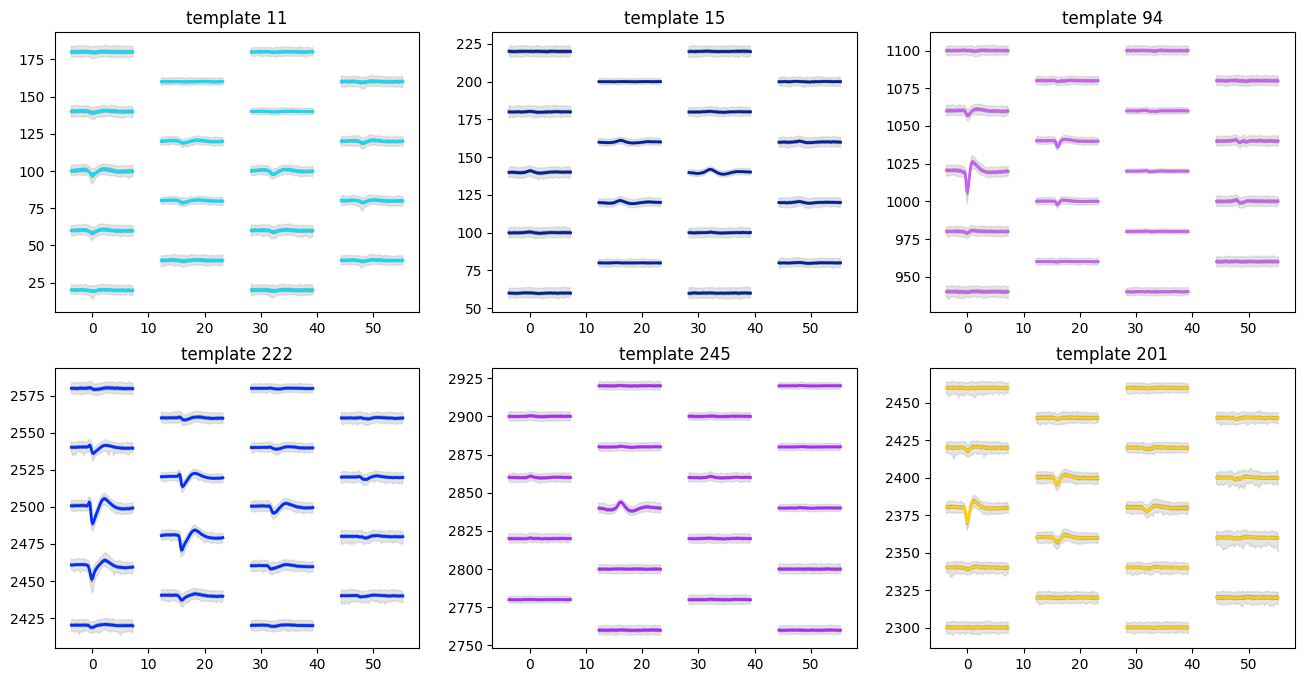

In [28]:
import os
import spikeinterface.full as si  # Assuming `si` is the module for loading the analyzer
import numpy as np
import pandas as pd  # Ensure Pandas is imported
import matplotlib.pyplot as plt
from pathlib import Path  # For modern path handling

analyzer = si.load_sorting_analyzer("D:/Florian_paper/Florian/Data/batch3/M9_1/analyzer_clean")  # Convert to string if needed
#tm = analyzer.compute('template_metrics')

unit_ids = analyzer.unit_ids

si.plot_unit_templates(analyzer, unit_ids=[11, 15,94,
                                          222,245,201], ncols=3, figsize=(16, 8))
plt.savefig('C:/Users/Freitag/Desktop/foo.pdf')

In [15]:
!phy template-gui D:\Florian_paper\Florian\Data\Batch3\M9_1\sorted\phy

11:56:46.621 [E] __init__:62          An error has occurred (PermissionError): [Errno 13] Permission denied: 'D:\\Florian_paper\\Florian\\Data\\Batch3\\M9_1\\sorted\\phy'
Traceback (most recent call last):
  File "C:\Users\Freitag\AppData\Local\anaconda3\envs\si_env\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\Freitag\AppData\Local\anaconda3\envs\si_env\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\Freitag\AppData\Local\anaconda3\envs\si_env\Scripts\phy.exe\__main__.py", line 7, in <module>
    sys.exit(phycli())
  File "C:\Users\Freitag\AppData\Local\anaconda3\envs\si_env\lib\site-packages\click\core.py", line 1161, in __call__
    return self.main(*args, **kwargs)
  File "C:\Users\Freitag\AppData\Local\anaconda3\envs\si_env\lib\site-packages\click\core.py", line 1082, in main
    rv = self.invoke(ctx)
  File "C:\Users\Freitag\AppData\Local\anaconda3\envs\si_env\lib\site-packages\cli